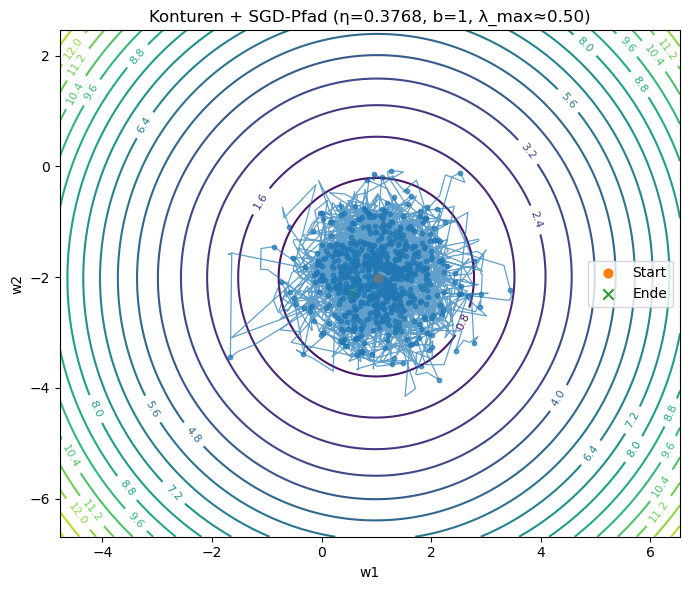

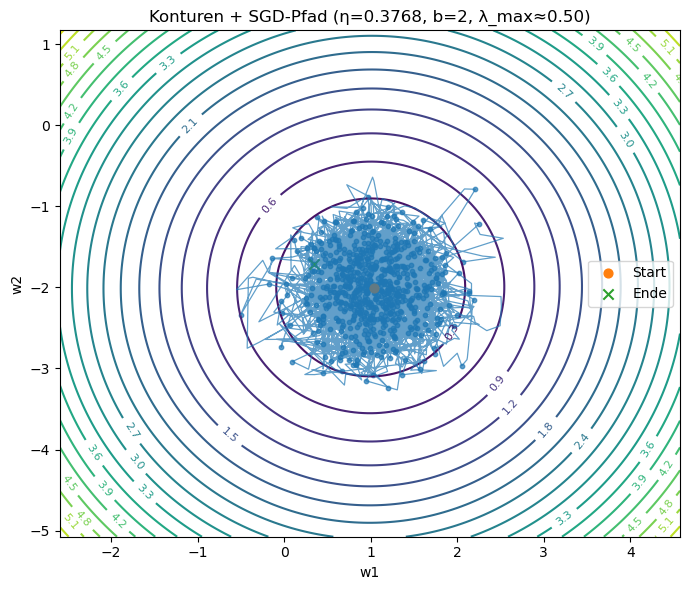

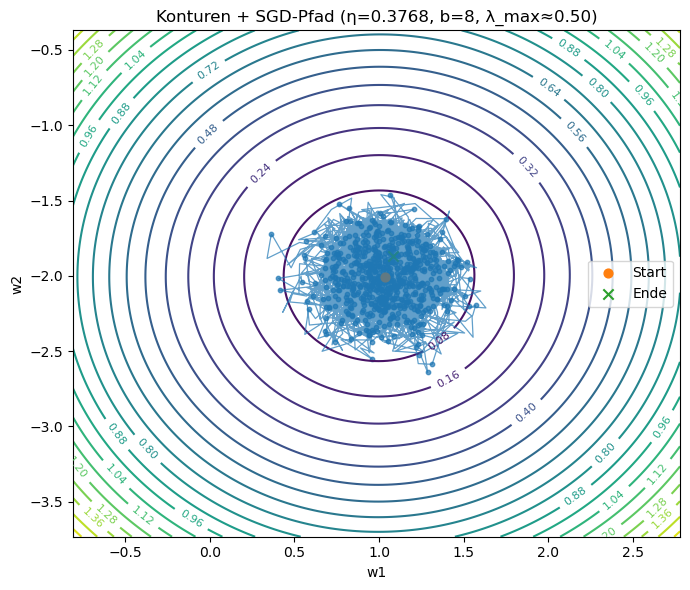

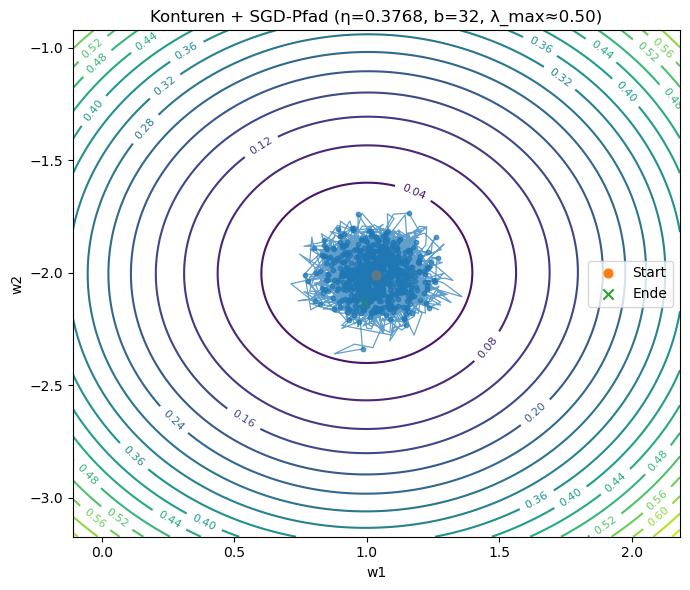

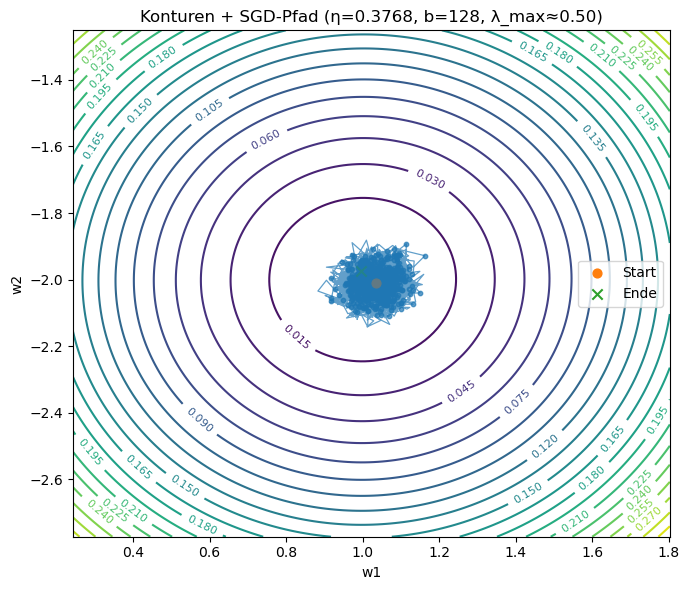

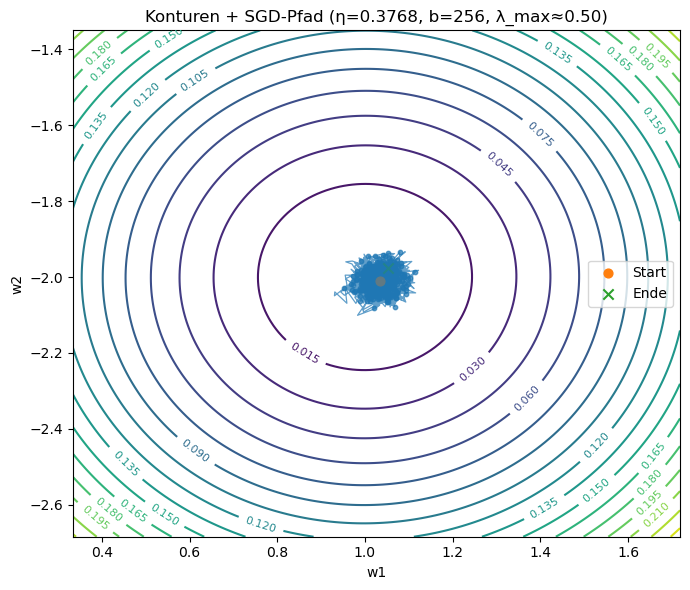

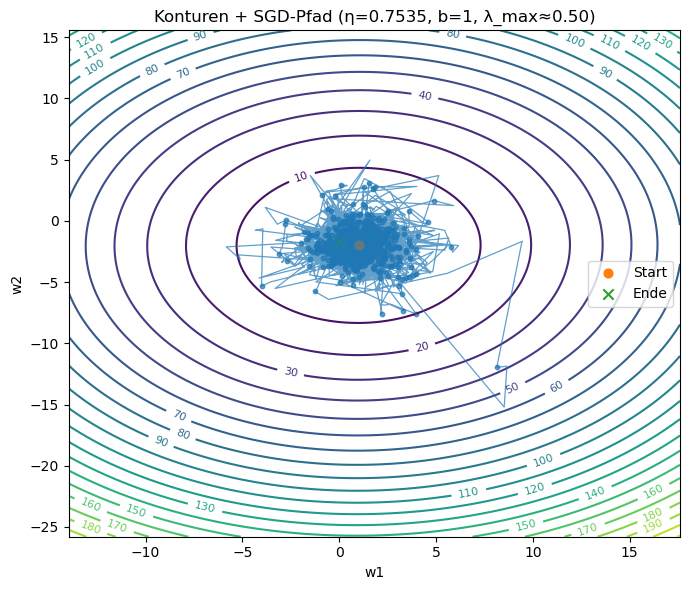

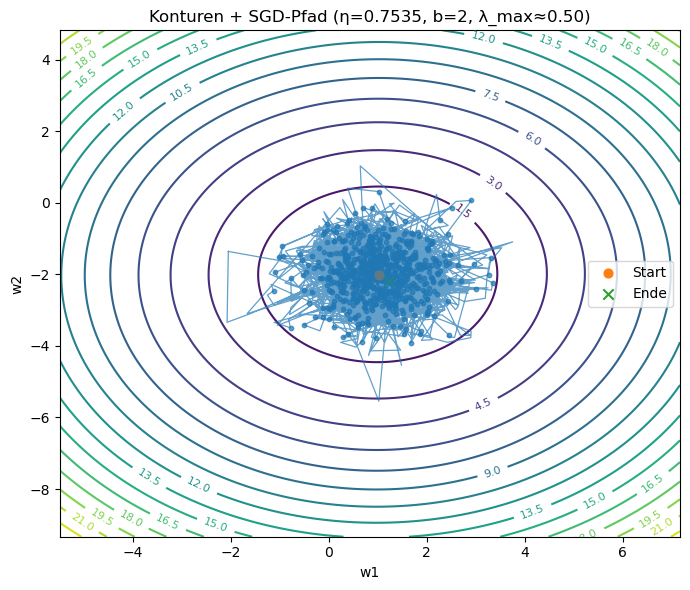

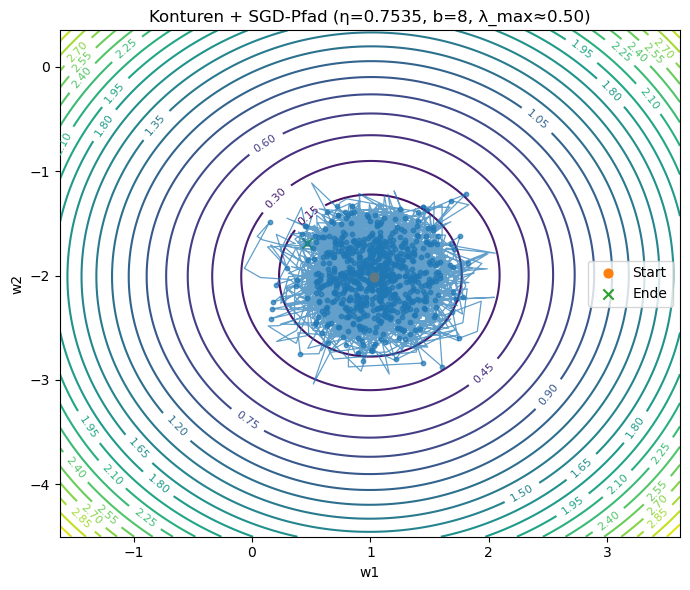

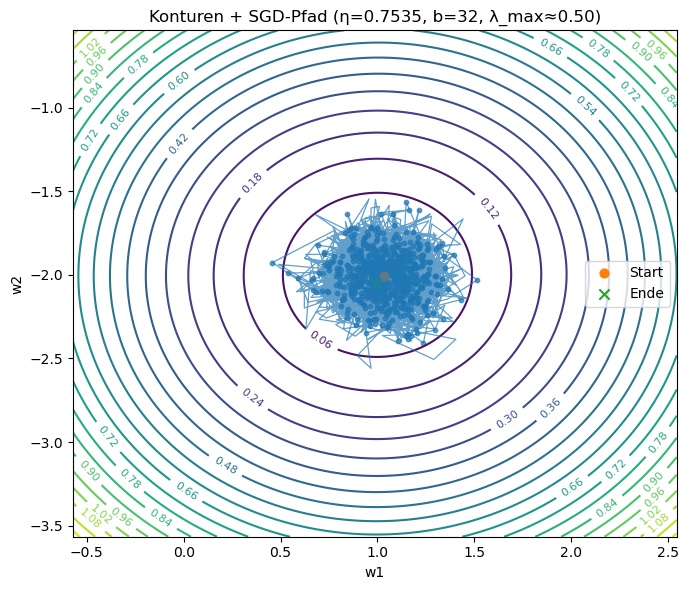

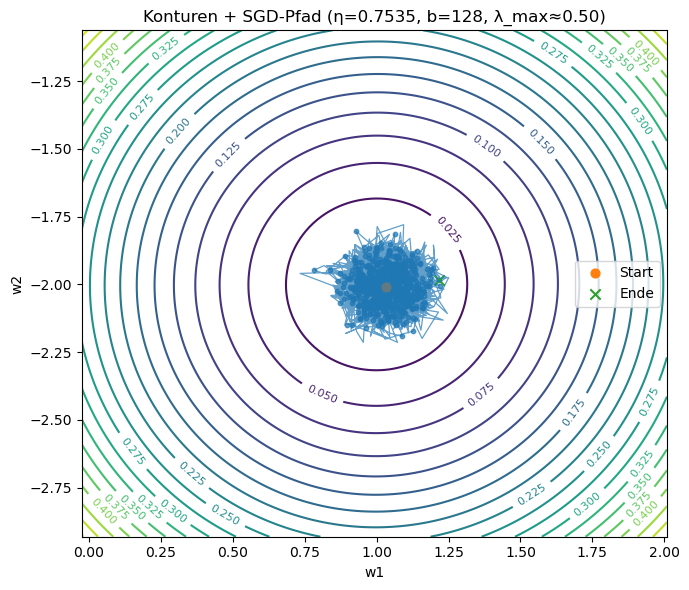

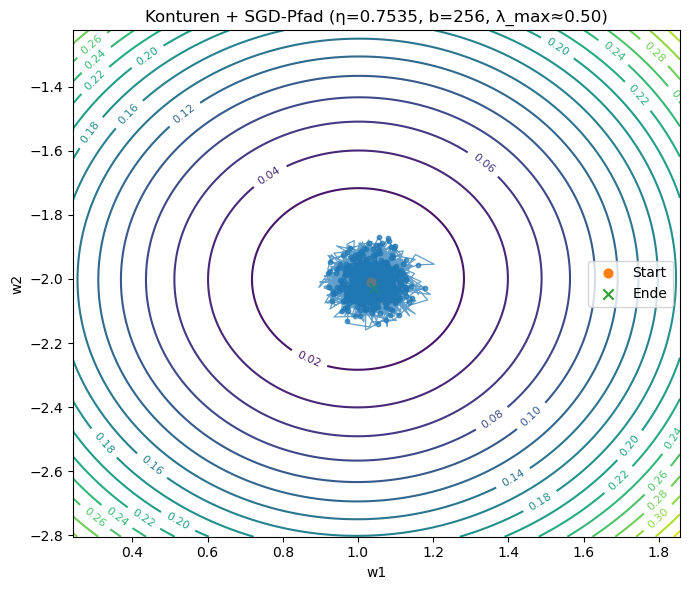

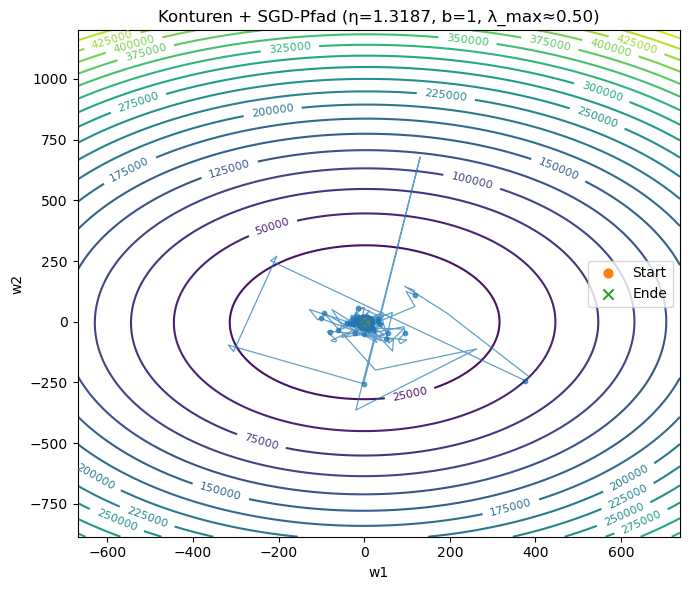

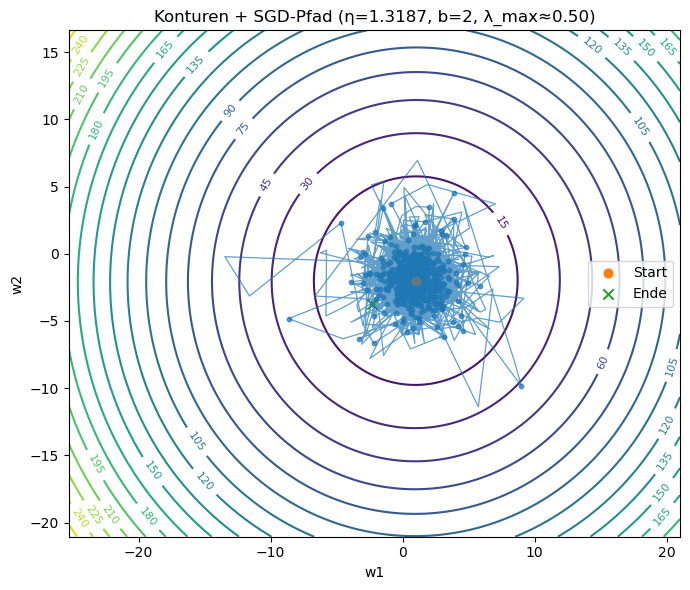

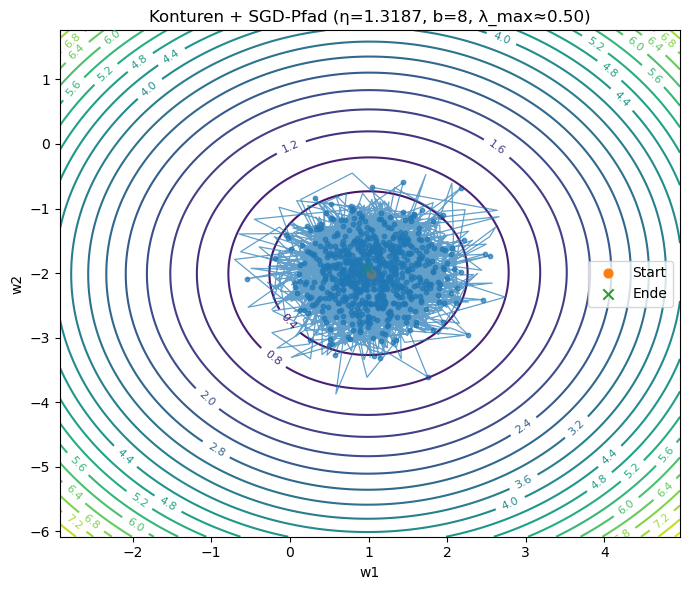

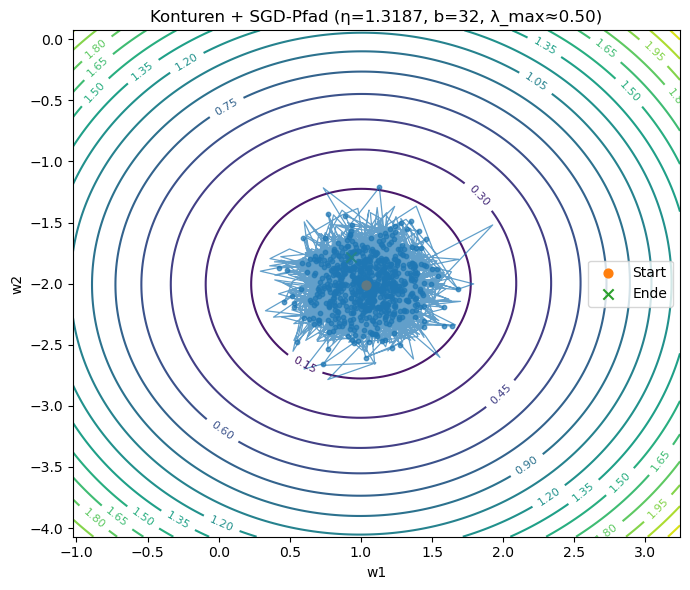

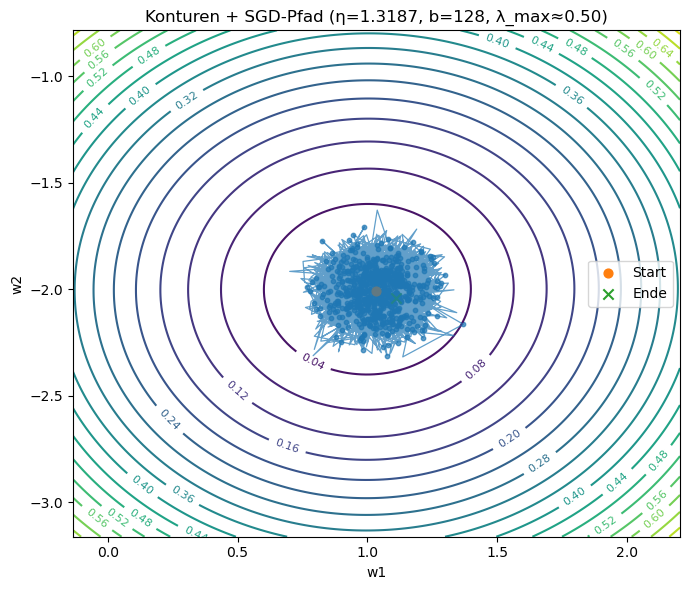

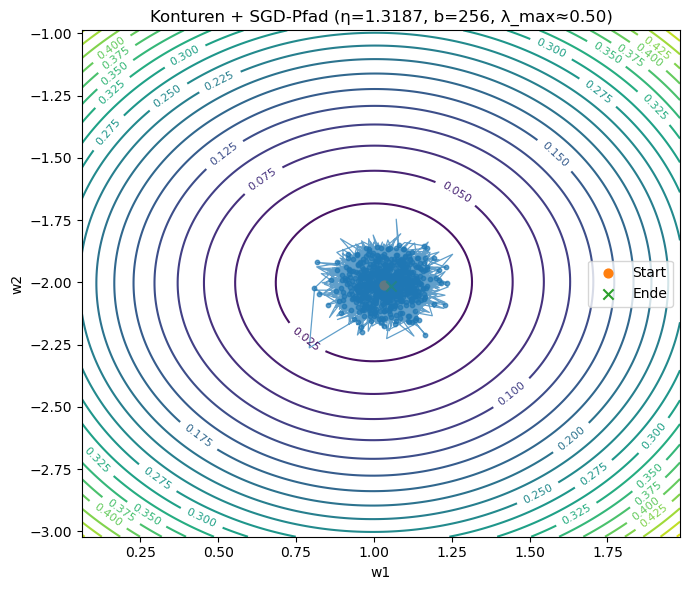

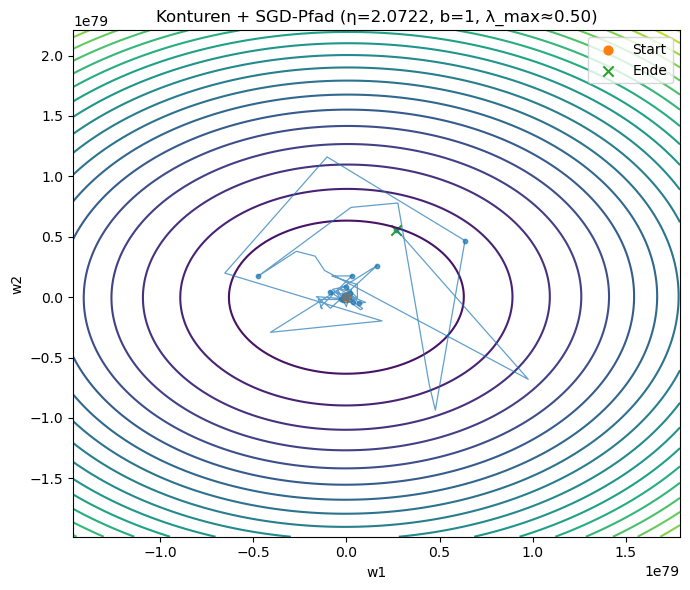

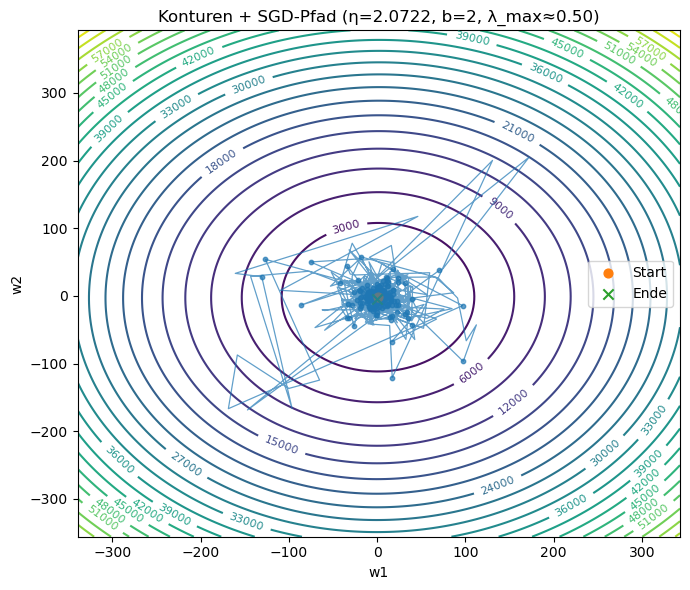

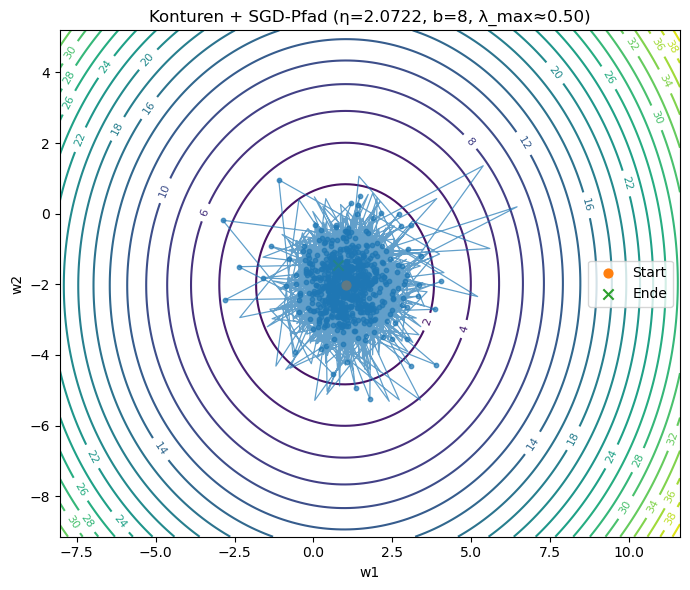

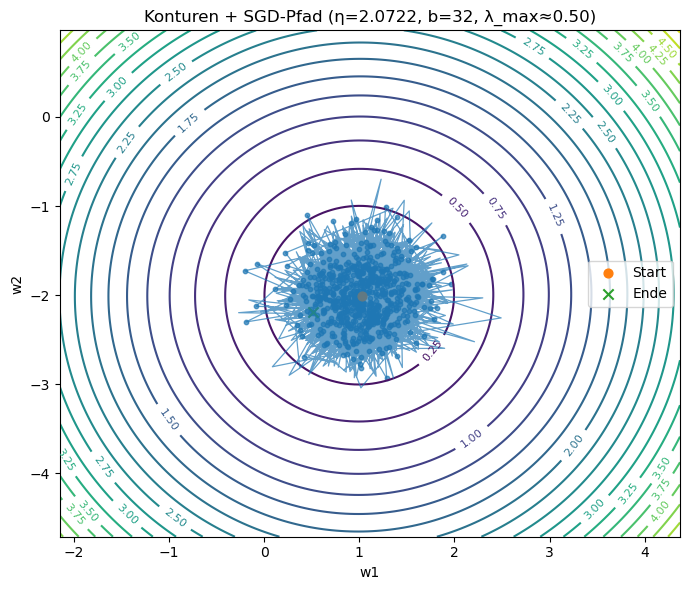

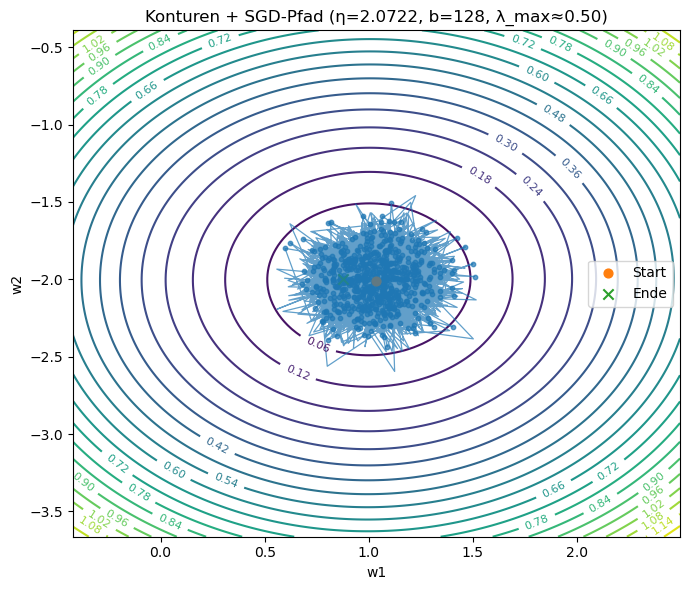

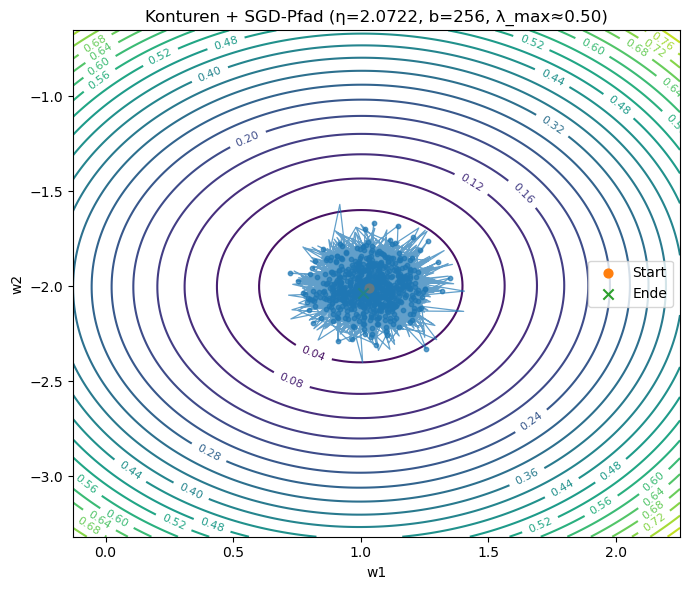

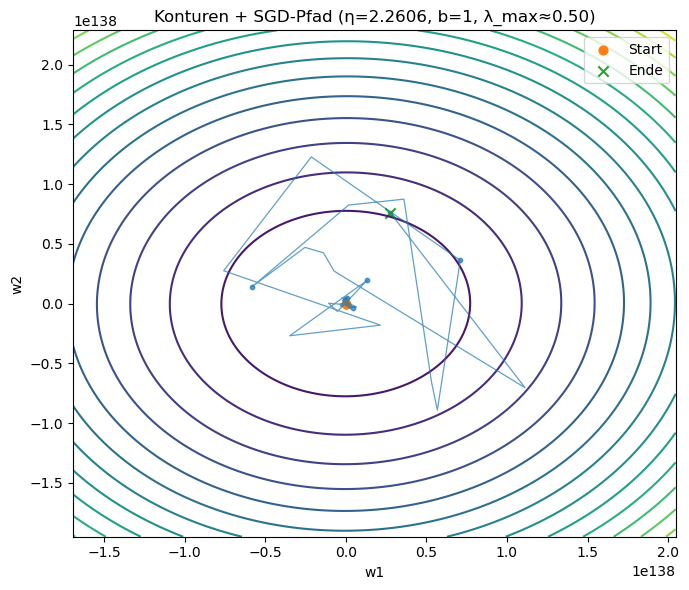

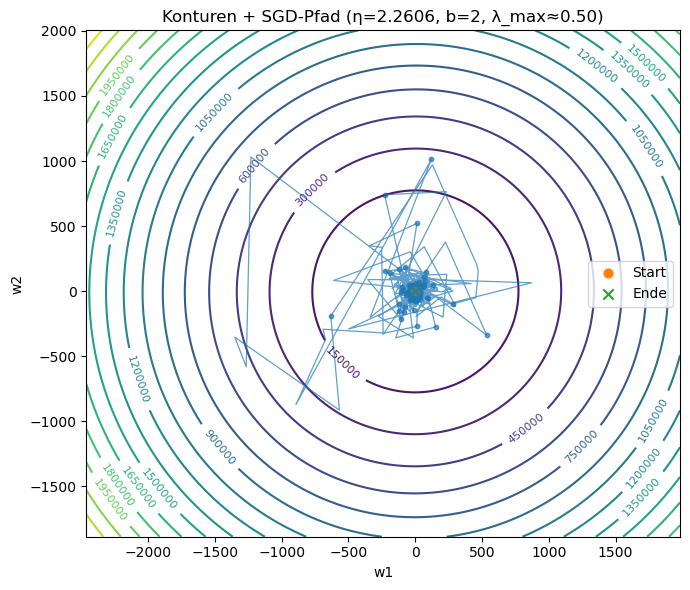

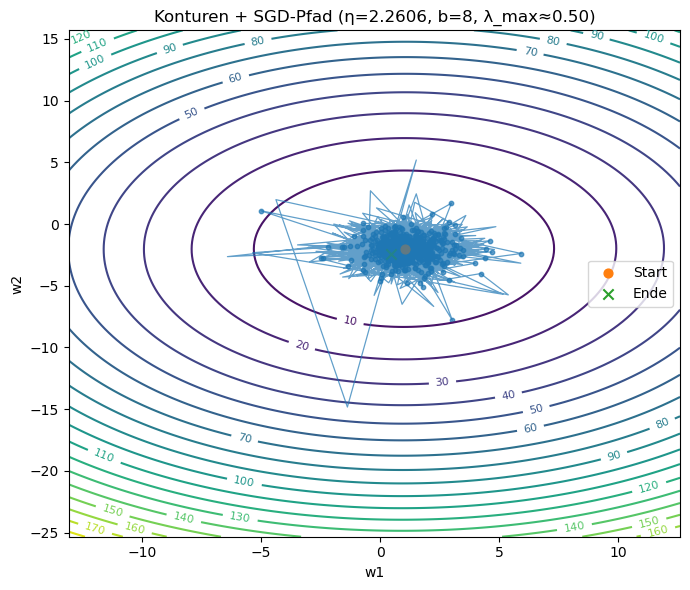

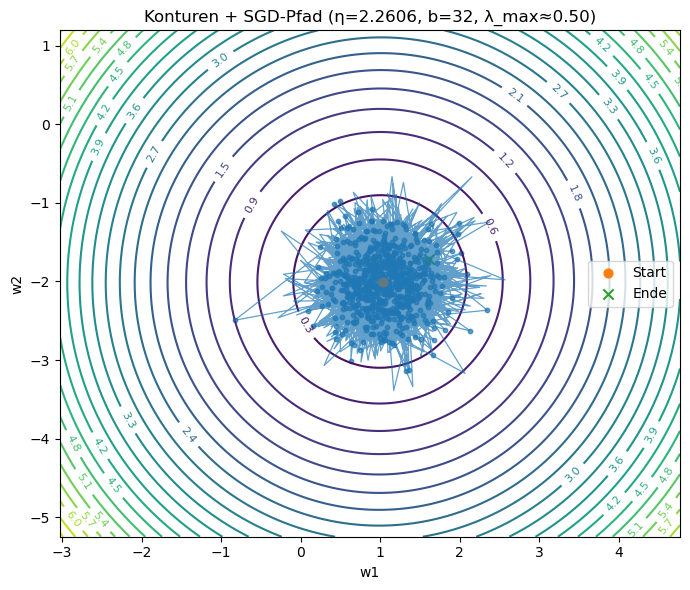

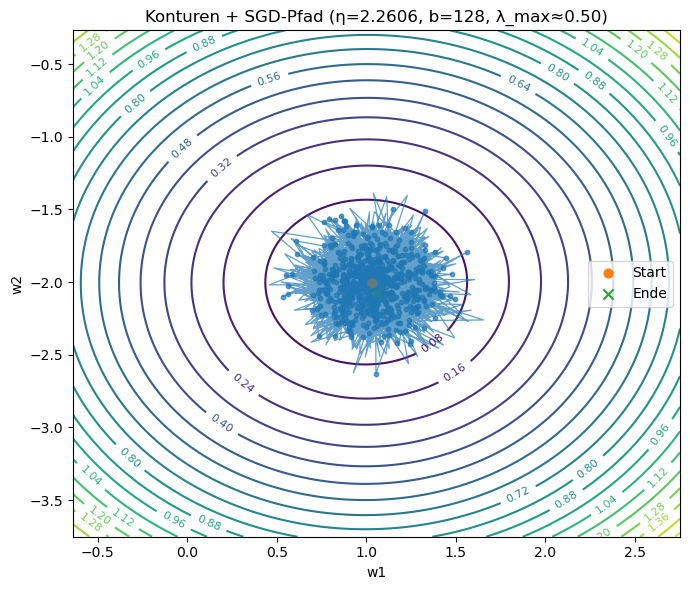

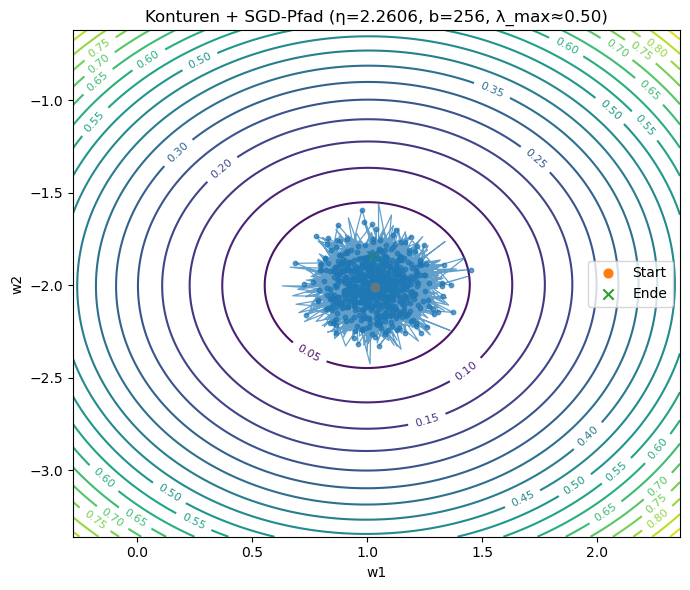

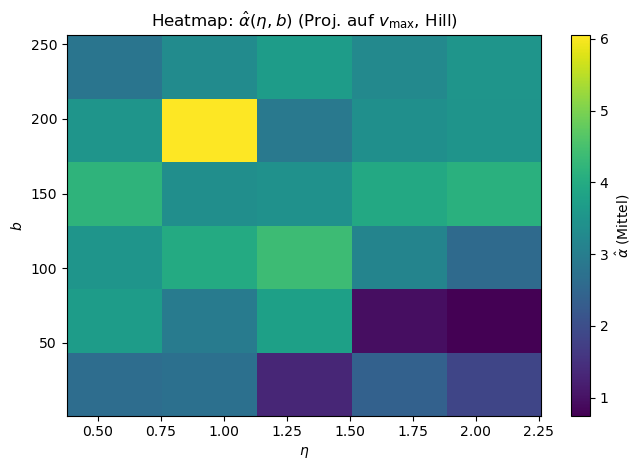

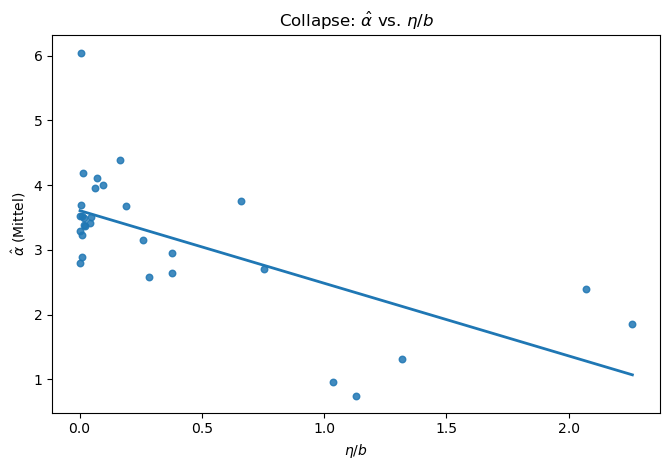

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from αEstimator import hill_α_estimator_Bootstrap_mse  # vorhanden in deinem Projekt

rng = np.random.default_rng(123)

# =========================
# Datengenerierung / Krümmung
# =========================
def make_data_curvature(n=4000, lambdas_cov=(1.0, 0.25), theta_deg=20.0, noise_std=0.8):
    """
    Erzeugt X so, dass (1/n) X^T X ≈ R diag(lambdas_cov) R^T.
    Für MSE ist H = (2/n) X^T X -> H-Eigenwerte ≈ 2 * lambdas_cov.
    """
    Z  = rng.normal(0.0, 1.0, size=(n, 2))
    s1, s2 = np.sqrt(lambdas_cov[0]), np.sqrt(lambdas_cov[1])
    S = np.diag([s1, s2])
    th = np.deg2rad(theta_deg)
    R = np.array([[np.cos(th), -np.sin(th)],
                  [np.sin(th),  np.cos(th)]])
    X = Z @ S @ R.T
    w_true = np.array([1.0, -2.0])
    y = X @ w_true + rng.normal(0.0, noise_std, size=n)
    cov = (X.T @ X) / n
    evals, _ = np.linalg.eigh(cov)  # Kovarianz-Eigenwerte
    return X, y, evals

# =========================
# Loss / Grad / SGD
# =========================
def mse_loss(X, y, w):
    r = X @ w - y
    return np.mean(r*r)

def mse_grad_batch(Xb, yb, w):
    b = Xb.shape[0]
    r = Xb @ w - yb
    return (2.0/b) * (Xb.T @ r)

def sgd(X, y, w0, eta, batch_size, steps, shuffle=True):
    n   = X.shape[0]
    idx = np.arange(n)
    w   = w0.copy()
    ws  = [w.copy()]
    ptr = 0
    order = idx.copy()
    for _ in range(steps):
        if shuffle:
            if ptr + batch_size > n:
                rng.shuffle(order); ptr = 0
            bidx = order[ptr:ptr+batch_size]; ptr += batch_size
        else:
            bidx = rng.choice(idx, size=batch_size, replace=False)
        Xb, yb = X[bidx], y[bidx]
        g = mse_grad_batch(Xb, yb, w)
        w = w - eta*g
        ws.append(w.copy())
    return w, np.asarray(ws)

# =========================
# HVP / Power-Iteration (λ_max, v_max)
# =========================
def hvp_full_mse(X, v):
    n = X.shape[0]
    H = (2.0/n) * (X.T @ X)
    return H @ v

def power_iter(X, tol=1e-8, maxit=10000):
    v = rng.normal(size=(2,))
    v = v / (np.linalg.norm(v) + 1e-12)
    lam_old = None
    for _ in range(maxit):
        hv = hvp_full_mse(X, v)
        lam = (v @ hv) / (v @ v + 1e-12)
        if lam_old is not None and abs(lam - lam_old) < tol:
            break
        v = hv / (np.linalg.norm(hv) + 1e-12)
        lam_old = lam
    return float(lam), v

# =========================
# Tail-Index-Schätzung (Hill)
# =========================
def estimate_alpha_from_series(T_series):
    T = np.asarray(T_series, float)
    T = np.abs(T)  # Magnitude-Tail
    out = hill_α_estimator_Bootstrap_mse(T)
    alpha_hat = float(out[0]) if len(out) >= 1 else np.nan
    lo        = float(out[2]) if len(out) >= 3 else np.nan
    hi        = float(out[3]) if len(out) >= 4 else np.nan
    mse       = float(out[4]) if len(out) >= 5 else np.nan
    return alpha_hat, lo, hi, mse

# =========================
# Konturen-Plot (dein Stil)
# =========================
def plot_landscape_and_path_light(X, w_path, title, levels=22, mark_every=4):
    """
    Konturen der MSE-Landschaft + SGD-Pfad als leichte Linie mit Punkten.
    """
    ws = np.asarray(w_path)
    w1_min, w1_max = ws[:,0].min(), ws[:,0].max()
    w2_min, w2_max = ws[:,1].min(), ws[:,1].max()
    pad1 = 0.5*(w1_max - w1_min + 1.0)
    pad2 = 0.5*(w2_max - w2_min + 1.0)
    W1 = np.linspace(w1_min - pad1, w1_max + pad1, 140)
    W2 = np.linspace(w2_min - pad2, w2_max + pad2, 140)
    G1, G2 = np.meshgrid(W1, W2, indexing="xy")
    L = np.zeros_like(G1)
    
    y_ref = X @ np.array([1.0, -2.0])
    for i in range(G1.shape[0]):
        for j in range(G1.shape[1]):
            wtmp = np.array([G1[i,j], G2[i,j]])
            L[i,j] = mse_loss(X, y_ref, wtmp)

    plt.figure(figsize=(7,6))
    cs = plt.contour(G1, G2, L, levels=levels)
    plt.clabel(cs, inline=True, fontsize=8)
    
    plt.plot(ws[:,0], ws[:,1], linewidth=0.9, alpha=0.7)
    sel = np.arange(0, len(ws), mark_every)
    plt.scatter(ws[sel,0], ws[sel,1], s=10, alpha=0.7)
    plt.scatter([ws[0,0]],[ws[0,1]], s=40, marker='o', label='Start')
    plt.scatter([ws[-1,0]],[ws[-1,1]], s=55, marker='x', label='Ende')
    plt.xlabel("w1"); plt.ylabel("w2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# =========================
# η–/b–Grid-Experiment + pro Konfiguration Konturenplot
# =========================
def run_eta_b_grid_and_plot_contours():
    # ----- 1) Fixe Geometrie / Daten -----
    n = 4000
    noise_std = 0.8
    lambdas_cov = (0.25, 0.25)  # moderate Anisotropie
    theta_deg = 25.0

    X, y, cov_eigs = make_data_curvature(n=n, lambdas_cov=lambdas_cov,
                                         theta_deg=theta_deg, noise_std=noise_std)
    # OLS-Optimum
    w_star = np.linalg.lstsq(X, y, rcond=None)[0]

    # Spektral-Krümmung
    lam_max, v_max = power_iter(X, tol=1e-8)

    # Schrittweiten-Skala: Bruchteile von 2/λ_max
    eta_max  = 2.0 / lam_max
    eta_fracs = np.array([0.10, 0.20, 0.35, 0.55, 0.60])
    eta_list  = (0.95 * eta_fracs * eta_max).tolist()

    # Batchgrößen
    b_list = [1, 2, 8, 32, 128, 256]

    # Lauf-Parameter
    steps = 3500
    burn  = 0.70
    thin  = 10
    R     = 3   # Replikate je (η,b)

    # ----- 2) Grid laufen lassen -----
    results = []
    for eta in eta_list:
        for b in b_list:
            alpha_vals, lo_vals, hi_vals = [], [], []
            contour_plotted = False  # genau EIN Konturenplot pro (eta,b)
            for r in range(R):
                # stationär um w_star
                w_end, path = sgd(X, y, w_star, eta=eta, batch_size=b, steps=steps, shuffle=True)

                # (a) Konturenplot (nur für r==0)
                if (not contour_plotted) and (r == 0):
                    plot_landscape_and_path_light(
                        X, path,
                        title=f"Konturen + SGD-Pfad (η={eta:.4f}, b={b}, λ_max≈{lam_max:.2f})",
                        levels=22, mark_every=5
                    )
                    contour_plotted = True

                # (b) Tail-Schätzung
                xi = path - w_end
                xi_used = xi[int(burn*len(xi))::thin]
                T_series = xi_used @ v_max
                a_hat, lo, hi, _ = estimate_alpha_from_series(T_series)
                alpha_vals.append(a_hat); lo_vals.append(lo); hi_vals.append(hi)

            results.append({
                "eta": eta, "b": b,
                "alpha_mean": float(np.nanmean(alpha_vals)),
                "alpha_lo_mean": float(np.nanmean(lo_vals)),
                "alpha_hi_mean": float(np.nanmean(hi_vals)),
                "lam_max": lam_max
            })
    return results, lam_max, eta_list, b_list

# =========================
# Plots: Heatmap + Collapse (weiterhin die wichtigsten)
# =========================
def plot_alpha_heatmap(results, eta_list, b_list):
    A = np.full((len(b_list), len(eta_list)), np.nan)
    for i, b in enumerate(b_list):
        for j, eta in enumerate(eta_list):
            vals = [r["alpha_mean"] for r in results if (abs(r["eta"]-eta)<1e-15 and r["b"]==b)]
            if len(vals):
                A[i, j] = np.nanmean(vals)
    plt.figure(figsize=(6.8,4.8))
    extent = [min(eta_list), max(eta_list), min(b_list), max(b_list)]
    plt.imshow(A, origin='lower', aspect='auto', extent=extent)
    plt.colorbar(label=r'$\hat{\alpha}$ (Mittel)')
    plt.xlabel(r'$\eta$'); plt.ylabel(r'$b$')
    plt.title(r'Heatmap: $\hat{\alpha}(\eta,b)$ (Proj. auf $v_{\max}$, Hill)')
    plt.tight_layout(); plt.show()

def plot_collapse(results):
    xs = np.array([r["eta"]/r["b"] for r in results])
    ys = np.array([r["alpha_mean"] for r in results])
    plt.figure(figsize=(6.8,4.8))
    plt.scatter(xs, ys, s=22, alpha=0.85)
    # schlanker linearer Fit
    Xmat = np.column_stack([np.ones_like(xs), xs])
    beta = np.linalg.lstsq(Xmat, ys, rcond=None)[0]
    xg = np.linspace(xs.min(), xs.max(), 200)
    yg = beta[0] + beta[1]*xg
    plt.plot(xg, yg, lw=2)
    plt.xlabel(r'$\eta/b$'); plt.ylabel(r'$\hat{\alpha}$ (Mittel)')
    plt.title(r'Collapse: $\hat{\alpha}$ vs. $\eta/b$')
    plt.tight_layout(); plt.show()

# =========================
# MAIN
# =========================
if __name__ == "__main__":
    results, lam_max, eta_list, b_list = run_eta_b_grid_and_plot_contours()
    # Wichtigste Summaries:
    plot_alpha_heatmap(results, eta_list, b_list)
    plot_collapse(results)
